# **Slovenia data**

Running this notebook does not require a GPU. You can use a frontal node. However, certain parts such as detecting bounding boxes or removing the background from images require GPUs which are launched in external jobs.

In [3]:
# Allow reloading of libraries without restarting the kernel
%load_ext autoreload
%autoreload 2

In [7]:
import os
import re
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from PIL import Image
from pathlib import Path

from lynx_id.utils.preprocess.utils import remove_basename_duplicates, check_filepath, flatten_bbox, get_no_and_multiple_bbox, separate_single_multiple_df, plot_images_conf, absolute_coordinates_bbox
from lynx_id.utils.megadetector.utils import crop_bbox

from idr_pytools import display_slurm_queue, gpu_jobs_submitter, search_log
from megadetector.detection.run_detector_batch import load_and_run_detector_batch, write_results_to_file
from megadetector.utils import path_utils

os.environ['WANDB_DISABLED'] = 'true'  # for megadetector

In [8]:
# GPU parameters for jobs to be launched (MegaDetector + SAM)
MODULE = 'pytorch-gpu/py3/2.2.0'
account = 'ads@v100'

In [9]:
DATASET = Path("/gpfsscratch/rech/ads/commun/datasets/extracted/")
COUNTRY = "slovenia"
SLOVENIA_DATASET_PATH = DATASET / "slovenia/Slovenia_Krofel"
NO_BACKGROUND = Path("/gpfsscratch/rech/ads/commun/datasets/extracted/no_background_new")

---

## **Get images (filepath + lynx_id)**

In [5]:
dataset_dict = {
    "filepath": [],
    "lynx_id": [],
    "date": [],
    "location": [],
    "longitude": [],
    "latitude": [],
    "country": [],
    "sex": [],
}

In [6]:
cnt_individuals = 0

for current_directory, _, files in os.walk(SLOVENIA_DATASET_PATH):
    for file in files:
        absolute_path = os.path.abspath(os.path.join(current_directory, file))
        if absolute_path.endswith(".csv") and 'Doru' not in absolute_path:  # 1 csv = 1 individual
            cnt_individuals += 1
            # Extract data from the CSV
            individual_csv = pd.read_csv(absolute_path, encoding='ISO-8859-1')
            
            # Get filepath
            filepaths = individual_csv['Encounter.mediaAsset0']
            filepaths = filepaths.apply(lambda filepath: current_directory + "/" + Path(file).stem + "/" + filepath.replace(" ", ""))
            # Get date
            dates = pd.to_datetime(individual_csv['Encounter.year'].astype(str) + '-' + individual_csv['Encounter.month'].astype(str) + '-' + individual_csv['Encounter.day'].astype(str) + ' ' + individual_csv['Encounter.hour'].astype(str) + ':' + individual_csv['Encounter.minutes'].astype(str))

            dataset_dict["filepath"].extend(filepaths.tolist())
            dataset_dict["lynx_id"].extend(individual_csv['MarkedIndividual.nickname'].tolist())
            dataset_dict["date"].extend(dates.tolist())
            dataset_dict["location"].extend(individual_csv['Encounter.verbatimLocality'].tolist())  # locationID is always the same: Dinarides
            dataset_dict["longitude"].extend(individual_csv['Encounter.decimalLongitude'].tolist())
            dataset_dict["latitude"].extend(individual_csv['Encounter.decimalLatitude'].tolist())
            dataset_dict["country"].extend(individual_csv['Encounter.country'].tolist())
            dataset_dict["sex"].extend(individual_csv['Encounter.sex'].tolist())

print(f"{cnt_individuals=}")
# individual_csv

cnt_individuals=52


In [7]:
df_country = pd.DataFrame(dataset_dict)
df_country

,filepath,lynx_id,date,location,longitude,latitude,country,sex
0,/gpfsscratch/rech/ads/commun/datasets/extracte...,Nanos1,2021-08-29 18:37:00,LD_Col,14.1033,45.8814,Slovenia,Male
1,/gpfsscratch/rech/ads/commun/datasets/extracte...,Nanos1,2021-10-30 10:05:00,LD_Bukovje,14.0924,45.8225,Slovenia,Male
2,/gpfsscratch/rech/ads/commun/datasets/extracte...,Nanos1,2022-01-23 15:06:00,LD_Col,14.1033,45.8814,Slovenia,Male
3,/gpfsscratch/rech/ads/commun/datasets/extracte...,Nanos1,2022-03-02 15:54:00,LD_Col,14.1033,45.8814,Slovenia,Male
4,/gpfsscratch/rech/ads/commun/datasets/extracte...,Nanos1,2022-03-02 15:54:00,LD_Col,14.1033,45.8814,Slovenia,Male
...,...,...,...,...,...,...,...,...
2025,/gpfsscratch/rech/ads/commun/datasets/extracte...,Goru,2022-11-26 12:49:00,LD_Ribnica,14.7730,45.7510,Slovenia,Male
2026,/gpfsscratch/rech/ads/commun/datasets/extracte...,Goru,2023-04-17 14:59:00,LD_Ribnica,14.7730,45.7510,Slovenia,Male
2027,/gpfsscratch/rech/ads/commun/datasets/extracte...,Goru,2022-11-27 11:03:00,LD_Ribnica,14.7730,45.7510,Slovenia,Male
2028,/gpfsscratch/rech/ads/commun/datasets/extracte...,Goru,2023-02-06 00:21:00,LD_Ribnica,14.7349,45.7776,Slovenia,Male


In [8]:
df_country.nunique()

filepath     2027
lynx_id        52
date         1093
location       40
longitude     189
latitude      189
country         1
sex             2
dtype: int64

In [9]:
df_country["sex"].value_counts()

sex
Male      1391
Female     580
Name: count, dtype: int64

### **Deleting broken images**

In [10]:
all_files_exist = all(df_country['filepath'].apply(os.path.exists))
all_files_exist

True

## **Bounding box detection**

In [11]:
country_output_megadetector = DATASET / COUNTRY / f"bbox_{COUNTRY}.json"  # WARNING: change filename if needed
country_output_megadetector

PosixPath('/gpfsscratch/rech/ads/commun/datasets/extracted/slovenia/bbox_slovenia.json')

In [12]:
image_filenames = df_country['filepath'].tolist()
len(image_filenames)

2030

In [13]:
# Bounding box calculation is externalised to another job
image_filenames_path = f"image_filenames_{COUNTRY}.txt"
with open(image_filenames_path, 'w') as f:
    json.dump(image_filenames, f)

n_gpu = 1
command = f'run_megadetector.py --image_filenames_path {image_filenames_path} --output_megadetector {country_output_megadetector}'

jobid = gpu_jobs_submitter(command, n_gpu, MODULE, name=f"megadetector_{COUNTRY}",
                   account=account, time_max='04:00:00', constraint='v100-32g', qos='qos_gpu-t3')
print(f'jobid = {jobid}')

batch job 0: 1 GPUs distributed on 1 nodes with 1 tasks / 1 gpus per node and 10 cpus per task
Submitted batch job 325430
jobid = ['325430']


In [14]:
display_slurm_queue(name=f"megadetector_{COUNTRY}", timestep=60)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            325430   gpu_p13 megadete  uxp55sd  R       6:45      1 r6i2n6

 Done!


In [15]:
with open(country_output_megadetector, 'r') as f:
    bbox_country = json.load(f)

Some images may not have bounding boxes found.

In [16]:
no_bbox_country, multiple_bbox_country = get_no_and_multiple_bbox(bbox_country)

55 images have no bounding boxes detected.
20 images have several bounding boxes detected.
Total: 2030 images.


Absolute coordinates of the bounding box (x, y, width and height) based on the image dimensions

In [17]:
df_bbox_country = flatten_bbox(bbox_country, add_image_without_bbox=False, verbose=False)
df_bbox_country = absolute_coordinates_bbox(df_bbox_country)

df_bbox_country

,file,im_width,im_height,category,conf,x,y,width,height
0,/gpfsscratch/rech/ads/commun/datasets/extracte...,5152,3968,1,0.940,895.932800,1143.9744,1109.7408,642.8160
1,/gpfsscratch/rech/ads/commun/datasets/extracte...,5152,3968,1,0.971,2132.928000,1884.8000,1353.9456,1169.7664
2,/gpfsscratch/rech/ads/commun/datasets/extracte...,5152,3968,1,0.965,0.999488,1719.7312,1174.6560,1016.9984
3,/gpfsscratch/rech/ads/commun/datasets/extracte...,5152,3968,1,0.954,1584.755200,1417.7664,996.9120,524.9664
4,/gpfsscratch/rech/ads/commun/datasets/extracte...,5152,3968,1,0.971,285.987520,2120.8960,1040.7040,604.7232
...,...,...,...,...,...,...,...,...,...
1990,/gpfsscratch/rech/ads/commun/datasets/extracte...,6272,3528,1,0.961,1126.451200,1057.6944,1010.4192,809.6760
1991,/gpfsscratch/rech/ads/commun/datasets/extracte...,6272,3528,1,0.959,4531.520000,1178.7048,1229.9392,629.7480
1992,/gpfsscratch/rech/ads/commun/datasets/extracte...,6272,3528,1,0.956,2347.609600,1877.9544,1655.8080,802.9728
1993,/gpfsscratch/rech/ads/commun/datasets/extracte...,6272,3528,1,0.917,4902.822400,1309.9464,1006.6560,674.9064


In [18]:
df_bbox_country.nunique()['file']

1972

### **10 images cropped with the least confidence are displayed**

Only images with a single bounding box are displayed.

In [19]:
df_bbox_country_single_detection, df_bbox_country_multiple_detections = separate_single_multiple_df(df_bbox_country)

print(len(df_bbox_country_single_detection))
print(len(df_bbox_country_multiple_detections))

1949
46


In [20]:
%matplotlib inline

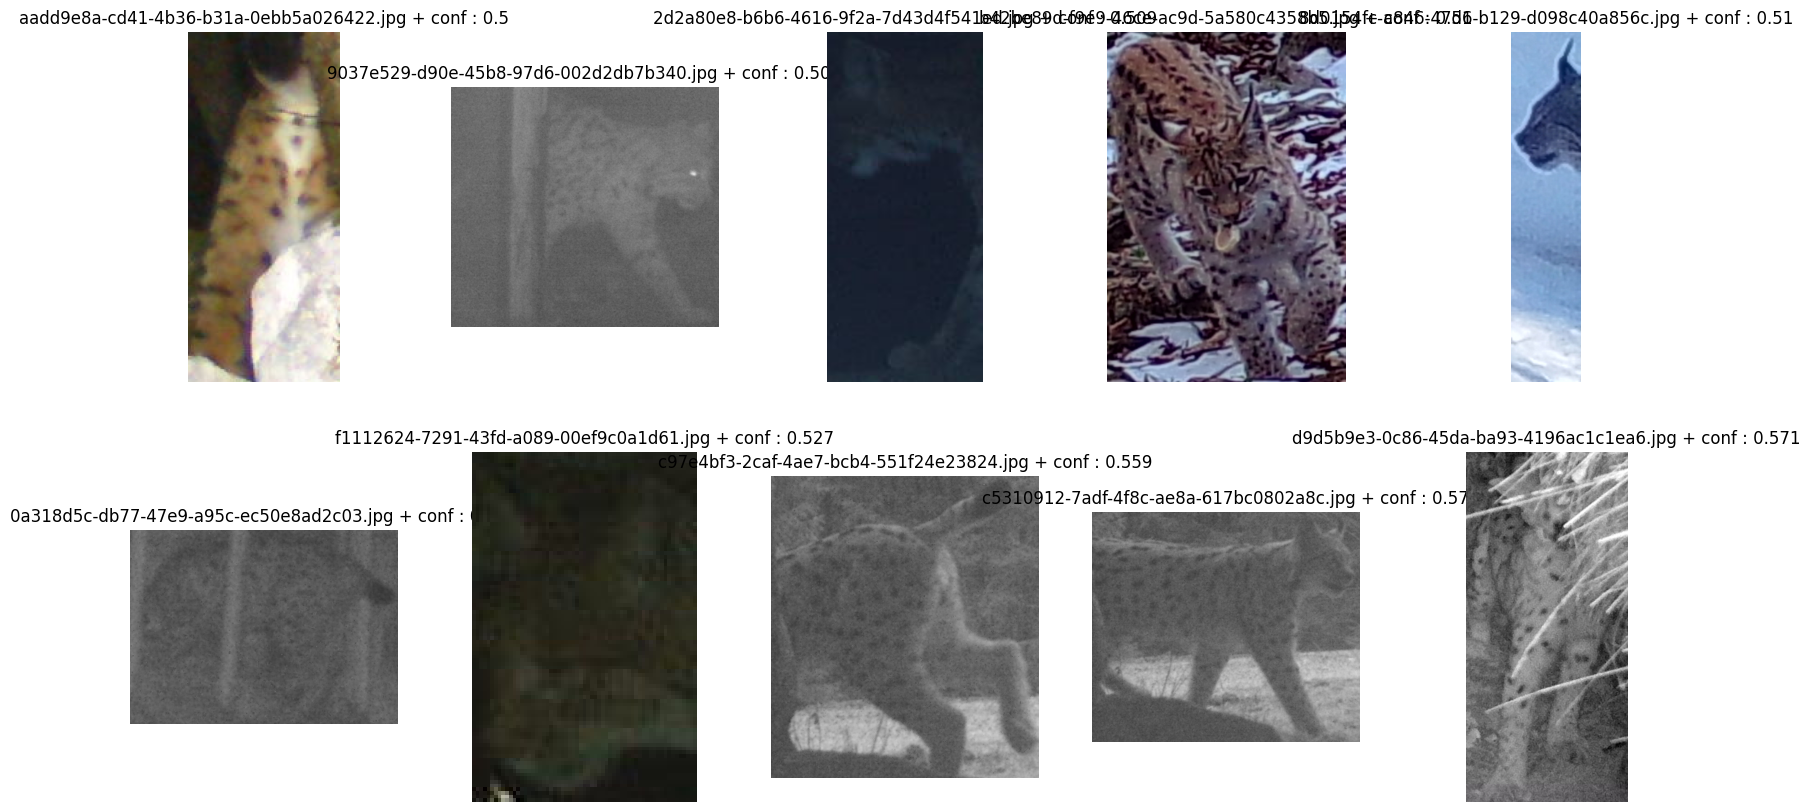

In [21]:
plot_images_conf(df_bbox_country_single_detection, by="smallest")

### **10 images cropped with the largest confidence are displayed**

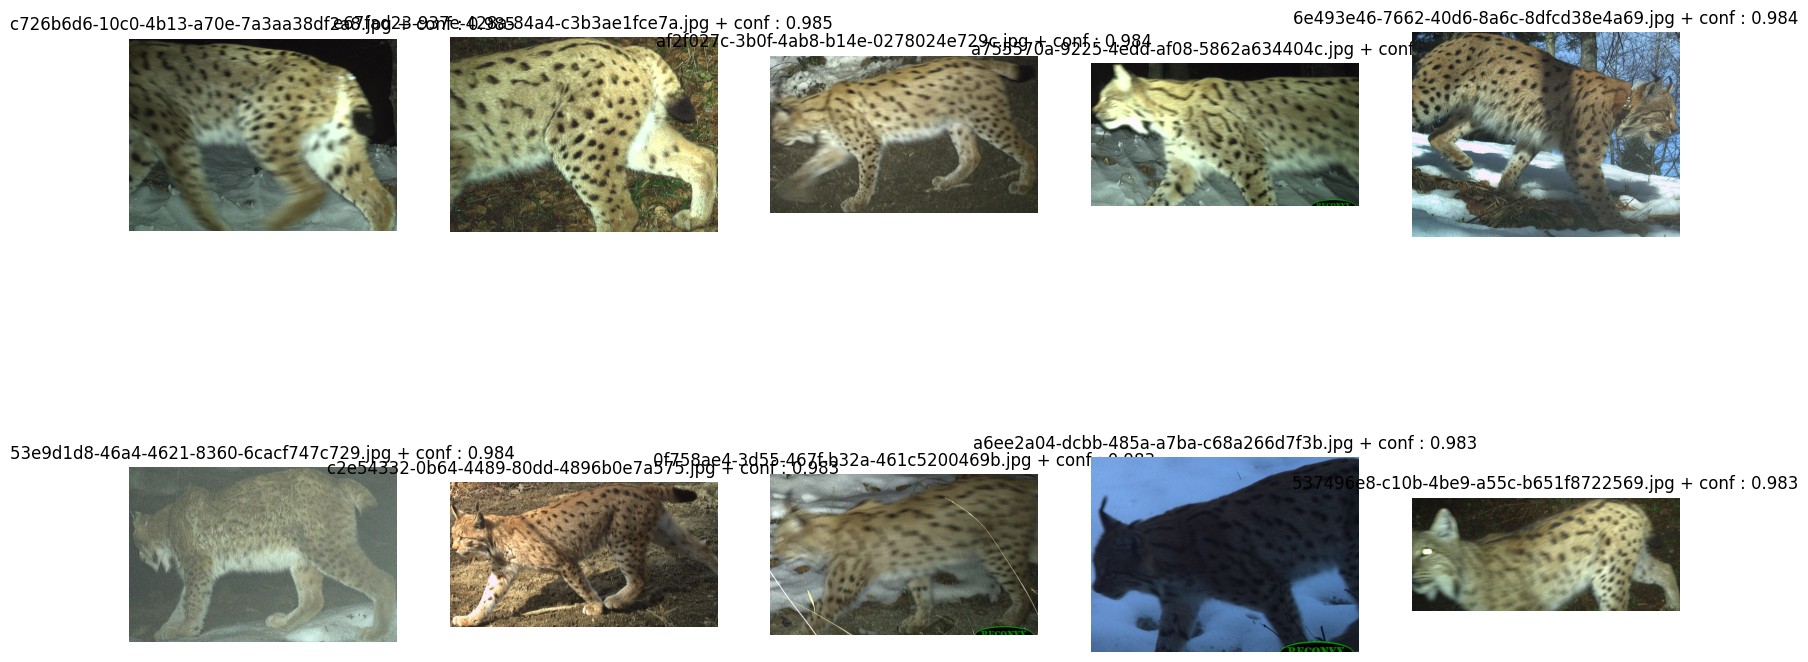

In [22]:
plot_images_conf(df_bbox_country_single_detection, by="largest")

In [23]:
df_country_with_bbox = pd.merge(df_country, df_bbox_country_single_detection[['file', 'conf', 'x', 'y', 'width', 'height']], how='inner', left_on='filepath', right_on='file')
df_country_with_bbox = df_country_with_bbox.drop('file', axis=1)

df_country_with_bbox

,filepath,lynx_id,date,location,longitude,latitude,country,sex,conf,x,y,width,height
0,/gpfsscratch/rech/ads/commun/datasets/extracte...,Nanos1,2021-08-29 18:37:00,LD_Col,14.1033,45.8814,Slovenia,Male,0.940,895.932800,1143.9744,1109.7408,642.8160
1,/gpfsscratch/rech/ads/commun/datasets/extracte...,Nanos1,2021-10-30 10:05:00,LD_Bukovje,14.0924,45.8225,Slovenia,Male,0.971,2132.928000,1884.8000,1353.9456,1169.7664
2,/gpfsscratch/rech/ads/commun/datasets/extracte...,Nanos1,2022-01-23 15:06:00,LD_Col,14.1033,45.8814,Slovenia,Male,0.965,0.999488,1719.7312,1174.6560,1016.9984
3,/gpfsscratch/rech/ads/commun/datasets/extracte...,Nanos1,2022-03-02 15:54:00,LD_Col,14.1033,45.8814,Slovenia,Male,0.954,1584.755200,1417.7664,996.9120,524.9664
4,/gpfsscratch/rech/ads/commun/datasets/extracte...,Nanos1,2022-03-02 15:54:00,LD_Col,14.1033,45.8814,Slovenia,Male,0.971,285.987520,2120.8960,1040.7040,604.7232
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1944,/gpfsscratch/rech/ads/commun/datasets/extracte...,Goru,2022-10-09 22:18:00,LD_Ribnica,14.7349,45.7776,Slovenia,Male,0.953,4685.811200,1762.9416,1534.7584,748.9944
1945,/gpfsscratch/rech/ads/commun/datasets/extracte...,Goru,2022-11-26 12:49:00,LD_Ribnica,14.7730,45.7510,Slovenia,Male,0.961,1126.451200,1057.6944,1010.4192,809.6760
1946,/gpfsscratch/rech/ads/commun/datasets/extracte...,Goru,2023-04-17 14:59:00,LD_Ribnica,14.7730,45.7510,Slovenia,Male,0.959,4531.520000,1178.7048,1229.9392,629.7480
1947,/gpfsscratch/rech/ads/commun/datasets/extracte...,Goru,2023-02-06 00:21:00,LD_Ribnica,14.7349,45.7776,Slovenia,Male,0.917,4902.822400,1309.9464,1006.6560,674.9064


#### Bounding box confidence distribution

<Axes: xlabel='conf', ylabel='Count'>

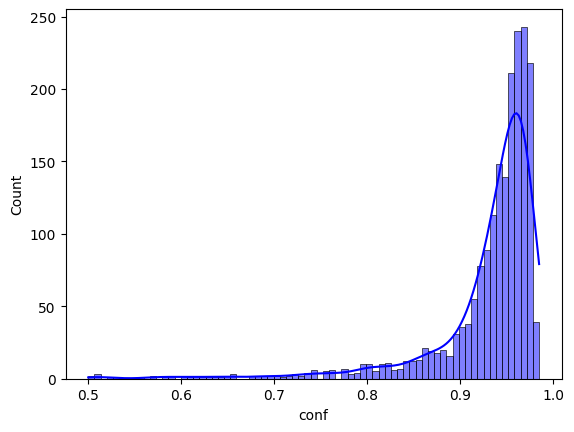

In [24]:
import seaborn as sns

sns.histplot(df_country_with_bbox["conf"], kde=True, color='blue')

## **Compute `image_number` for each individual**

This number is no longer the same as initially following filtering, particularly of images with no bounding box detected, for example.

In [25]:
df_country_with_bbox['image_number'] = df_country_with_bbox.groupby('lynx_id').cumcount() + 1
df_country_with_bbox

,filepath,lynx_id,date,location,longitude,latitude,country,sex,conf,x,y,width,height,image_number
0,/gpfsscratch/rech/ads/commun/datasets/extracte...,Nanos1,2021-08-29 18:37:00,LD_Col,14.1033,45.8814,Slovenia,Male,0.940,895.932800,1143.9744,1109.7408,642.8160,1
1,/gpfsscratch/rech/ads/commun/datasets/extracte...,Nanos1,2021-10-30 10:05:00,LD_Bukovje,14.0924,45.8225,Slovenia,Male,0.971,2132.928000,1884.8000,1353.9456,1169.7664,2
2,/gpfsscratch/rech/ads/commun/datasets/extracte...,Nanos1,2022-01-23 15:06:00,LD_Col,14.1033,45.8814,Slovenia,Male,0.965,0.999488,1719.7312,1174.6560,1016.9984,3
3,/gpfsscratch/rech/ads/commun/datasets/extracte...,Nanos1,2022-03-02 15:54:00,LD_Col,14.1033,45.8814,Slovenia,Male,0.954,1584.755200,1417.7664,996.9120,524.9664,4
4,/gpfsscratch/rech/ads/commun/datasets/extracte...,Nanos1,2022-03-02 15:54:00,LD_Col,14.1033,45.8814,Slovenia,Male,0.971,285.987520,2120.8960,1040.7040,604.7232,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1944,/gpfsscratch/rech/ads/commun/datasets/extracte...,Goru,2022-10-09 22:18:00,LD_Ribnica,14.7349,45.7776,Slovenia,Male,0.953,4685.811200,1762.9416,1534.7584,748.9944,453
1945,/gpfsscratch/rech/ads/commun/datasets/extracte...,Goru,2022-11-26 12:49:00,LD_Ribnica,14.7730,45.7510,Slovenia,Male,0.961,1126.451200,1057.6944,1010.4192,809.6760,454
1946,/gpfsscratch/rech/ads/commun/datasets/extracte...,Goru,2023-04-17 14:59:00,LD_Ribnica,14.7730,45.7510,Slovenia,Male,0.959,4531.520000,1178.7048,1229.9392,629.7480,455
1947,/gpfsscratch/rech/ads/commun/datasets/extracte...,Goru,2023-02-06 00:21:00,LD_Ribnica,14.7349,45.7776,Slovenia,Male,0.917,4902.822400,1309.9464,1006.6560,674.9064,456


## **Add other information**

In [50]:
needed_columns = ['source', 'pattern', 'date', 'location']
for col in needed_columns:
    if col not in df_country_with_bbox.columns:
        df_country_with_bbox[col] = np.nan

In [51]:
df_country_with_bbox['country'] = COUNTRY

In [52]:
df_country_with_bbox.to_csv(DATASET / COUNTRY / f"lynx_dataset_{COUNTRY}.csv", index=False)

## **Remove backgrounds**

Images without backgrounds are calculated using the `Segment Anything Model`. These are saved here: `/gpfsscratch/rech/ads/commun/datasets/extracted/no_background`.  
The csv file is completed with a `filepath_no_bg` column and saved here: `/gpfsscratch/rech/ads/commun/datasets/extracted/lynx_dataset_full_no_bg.csv`

In [5]:
df_country_with_bbox = pd.read_csv(DATASET / f"{COUNTRY}" / f"lynx_dataset_{COUNTRY}.csv")

### **Add the `filepath_no_bg` column based on existing images**

In [6]:
df_country_with_bbox['filepath_no_bg'] = df_country_with_bbox.apply(lambda row: check_filepath(NO_BACKGROUND, COUNTRY, row['filepath'], row['lynx_id'], row['image_number']), axis=1)

In [7]:
print(f"Number of images remaining to be calculated: {df_country_with_bbox['filepath_no_bg'].isna().sum()}")

Number of images remaining to be calculated: 1949


In [8]:
df_country_with_bbox.to_csv(DATASET / COUNTRY / f"lynx_dataset_{COUNTRY}.csv", index=False)

In [ ]:
display_slurm_queue(name=f'sam_{COUNTRY}', timestep=60)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            350839   gpu_p13 sam_slov  uxp55sd  R      35:23      1 r6i2n1


In [10]:
df_full = pd.read_csv(DATASET / f"{COUNTRY}" / f"lynx_dataset_{COUNTRY}.csv")

In [11]:
df_full.groupby('country').nunique()[['filepath', 'filepath_no_bg']]

,filepath,filepath_no_bg
country,,
slovenia,1949,1949


In [12]:
all_files_exist = df_full['filepath_no_bg'].apply(lambda x: pd.isna(x) or os.path.exists(x)).all()
assert all_files_exist

## **Handle duplicates**

In [18]:
pd.set_option('display.max_colwidth', None)

In [17]:
df_full['basename'] = df_full['filepath'].apply(os.path.basename)
df_full[df_full.duplicated(subset='basename', keep=False)]

,filepath,lynx_id,date,location,longitude,latitude,country,sex,conf,x,y,width,height,image_number,filepath_no_bg,source,pattern,score_sam,basename
586,/gpfsscratch/rech/ads/commun/datasets/extracted/slovenia/Slovenia_Krofel/wetransfer_lifelynx-slovenia-pictures-and-prepared-data-2_2023-11-06_1220/Teja(MalaGora1)/15b9a430-835d-4197-98de-8f3a3403d8dc.jpg,Teja(MalaGora1),2020-01-05 07:18:00,LD_Kocevje,14.8538,45.7098,slovenia,Female,0.963,0.00000,816.8128,511.8512,536.8704,29,/gpfsscratch/rech/ads/commun/datasets/extracted/no_background_new/slovenia/Teja(MalaGora1)/no_bg_29_15b9a430-835d-4197-98de-8f3a3403d8dc.jpg,NaN,NaN,0.984223,15b9a430-835d-4197-98de-8f3a3403d8dc.jpg
587,/gpfsscratch/rech/ads/commun/datasets/extracted/slovenia/Slovenia_Krofel/wetransfer_lifelynx-slovenia-pictures-and-prepared-data-2_2023-11-06_1220/Teja(MalaGora1)/dba4eb85-0069-406a-a247-6ecf73cce7b3.jpg,Teja(MalaGora1),2020-01-05 07:17:00,LD_Kocevje,14.8538,45.7098,slovenia,Female,0.951,207.98624,837.8432,362.9584,520.9984,30,/gpfsscratch/rech/ads/commun/datasets/extracted/no_background_new/slovenia/Teja(MalaGora1)/no_bg_30_dba4eb85-0069-406a-a247-6ecf73cce7b3.jpg,NaN,NaN,0.977394,dba4eb85-0069-406a-a247-6ecf73cce7b3.jpg
1493,/gpfsscratch/rech/ads/commun/datasets/extracted/slovenia/Slovenia_Krofel/wetransfer_lifelynx-slovenia-pictures-and-prepared-data_2023-11-06_1213/Goru/15b9a430-835d-4197-98de-8f3a3403d8dc.jpg,Goru,2020-01-05 07:18:00,LD_Kocevje,14.8538,45.7098,slovenia,Male,0.963,0.00000,816.8128,511.8512,536.8704,2,/gpfsscratch/rech/ads/commun/datasets/extracted/no_background_new/slovenia/Goru/no_bg_2_15b9a430-835d-4197-98de-8f3a3403d8dc.jpg,NaN,NaN,0.984223,15b9a430-835d-4197-98de-8f3a3403d8dc.jpg
1511,/gpfsscratch/rech/ads/commun/datasets/extracted/slovenia/Slovenia_Krofel/wetransfer_lifelynx-slovenia-pictures-and-prepared-data_2023-11-06_1213/Goru/dba4eb85-0069-406a-a247-6ecf73cce7b3.jpg,Goru,2020-01-05 07:17:00,LD_Kocevje,14.8538,45.7098,slovenia,Male,0.951,207.98624,837.8432,362.9584,520.9984,20,/gpfsscratch/rech/ads/commun/datasets/extracted/no_background_new/slovenia/Goru/no_bg_20_dba4eb85-0069-406a-a247-6ecf73cce7b3.jpg,NaN,NaN,0.977394,dba4eb85-0069-406a-a247-6ecf73cce7b3.jpg


2 images are duplicated for two different individuals. In these images, there are 2 lynxes. This case is not managed. These lines are deleted.

In [24]:
df_full = remove_basename_duplicates(df_full)

In [37]:
df_full.shape

(1945, 18)

In [36]:
df_full.to_csv(DATASET / COUNTRY / f"lynx_dataset_{COUNTRY}.csv", index=False)